# Sustainable Capitol Hill 2022 Anual Meeting

In 2021 the Capitol Hill Tool Library saw membership, checkouts, and return times move towards pre-pandemic levels.

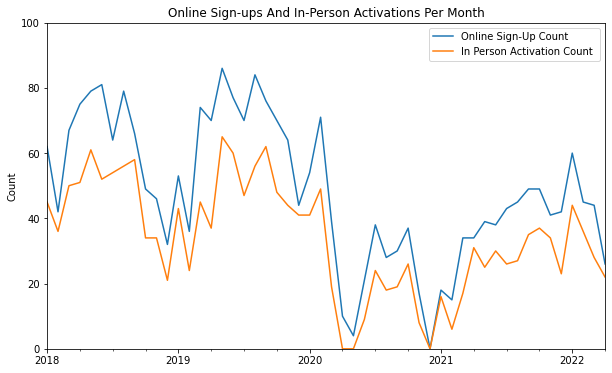

In [1]:
import numpy as np
import pandas as pd

members = pd.read_pickle('output/members.pkl')

def to_month(timestamp_series):
    return timestamp_series.apply(lambda t: pd.Timestamp(t.year, t.month, 1))

member_dates = pd.DataFrame(
    {
        'Online Sign-Up Count': members['Created'].groupby(to_month(members['Created'])).size().asfreq('MS',fill_value=0),
        'In Person Activation Count ': members['First Membership Started'].groupby(to_month(members['First Membership Started'])).size().asfreq('MS',fill_value=0)
    },
    index=pd.date_range(freq='MS', start=pd.Timestamp('2018-01-01'), end=pd.Timestamp('2022-04-01'))
)

graph = member_dates.plot(
    title='Online Sign-ups And In-Person Activations Per Month',
    figsize=(10, 6),
    ylabel='Count',
    ylim=(0,100),
)

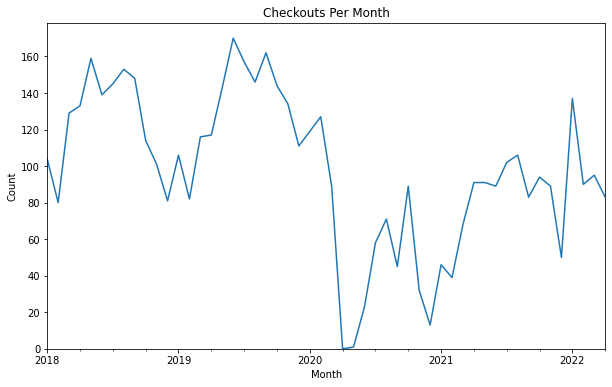

In [2]:
import pandas as pd
from datetime import date

checkouts = pd.read_pickle('output/checkouts.pkl')
checkouts['Month'] = pd.to_datetime(checkouts['Checked Out'].map(lambda c: date(c.year, c.month, 1)))
checkouts['Year'] = checkouts['Checked Out'].map(lambda c: c.year)
# Exclude 2015 (tool library not fully open) and current year if it is only a month or two in.
recent_years = checkouts[checkouts['Year'].isin([2018, 2019, 2020, 2021, 2022])]
by_month = recent_years.groupby('Month').size().asfreq('MS', fill_value=0)

# Save to a variable so the __str__ doesn't get displayed
graph = by_month.plot(figsize=(10, 6), title='Checkouts Per Month', ylabel='Count', ylim=0)

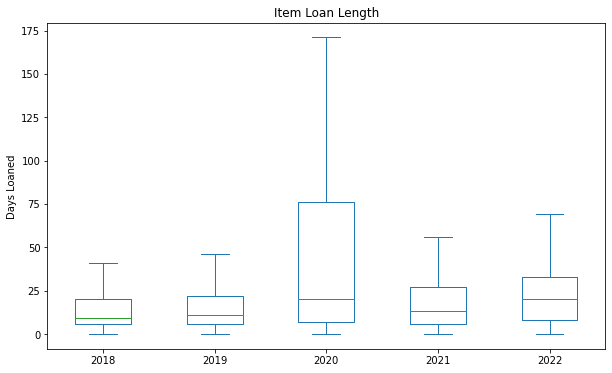

In [3]:
from datetime import date
import pandas as pd

loans = pd.read_pickle('output/loans.pkl')
loans['Length'] = loans['Checked In'].fillna(pd.to_datetime(date.today())) - loans['Checked Out']
loans['Year'] = loans['Checked Out'].map(lambda c: c.year)
recent_years = loans[loans['Year'].isin([2018, 2019, 2020, 2021, 2022])]

by_year = pd.DataFrame({'Days': recent_years['Length'].map(lambda l: l.days), 'Year': recent_years['Year']})
graph = by_year.pivot(columns='Year', values='Days').plot.box(
    # "fliers" in plt parlance are outliers.  We don't show them here because there are so many, they make the
    # rest of the plot much harder to read.  The gist is that a few loans are just never returned.
    showfliers=False,
    figsize=(10, 6),
    title='Item Loan Length',
    ylabel='Days Loaned',
)

## Member Demographics

We don't have reliable data on the race and gender makeup of our members. In the small group that have self-reported race and gender, white people and men are over-represented compared to Seattle as a whole.

Because members are required to provide a birthday as part of the sign-up process, we have a lot of data on member age.

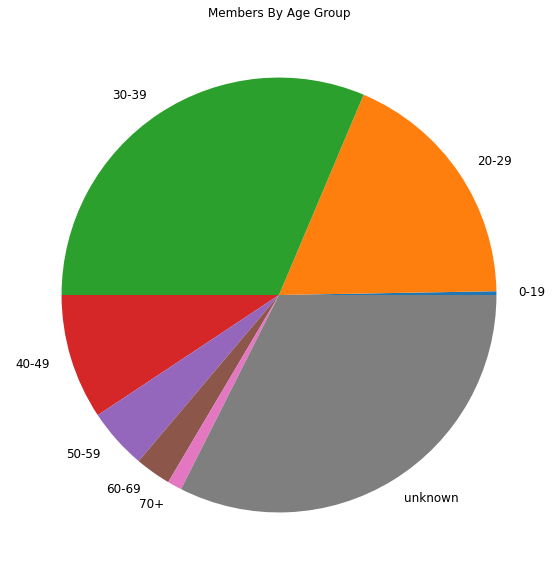

In [4]:
def age_group(age):
    if pd.isna(age):
        return 'unknown'
    
    age_digits = len(str(age))
    # We see a lot of ages that are the year of birth, e.g. 1992
    if age_digits == 4:
        age = int(str(age)[2:])
    elif age_digits != 2:
        return 'unknown'

    if age < 20:
        return '0-19'
    elif age >= 70:
        return '70+'
    else:
        # Rounds down to nearest 10
        clipped_age = (age // 10) * 10
        return f'{clipped_age}-{clipped_age+9}'

regular_members = pd.DataFrame(members[members['Current Membership Type'] != 'Request_CheckIDAddressPhoneDOB'])

by_age_group = regular_members.groupby(regular_members['Age'].apply(age_group)).size()
graph = by_age_group.plot.pie(
    ylabel='', title='Members By Age Group',
    fontsize='large',
    figsize=(10, 10)
)

## Member Stories

These are some of the projects I've heard people mention during my shifts:

> I just moved to Seattle, and want to hang a shelf but don't have any tools.

> I'm making lock-pick sets as a hobby and roped in some friends to help.

> I'm going clamming over the weekend but don't want to own a clam gun.

> I'm always working on a new woodworking project at the tool library.

> I'm practicing to enter a machinst program.

> I'd like to shorten this bit of metal shelving.

> I'm building sex toys, mostly.

> I'm demolishing my kitchen.

> I'm 3D printing a holder for a custom audio-jack switcher.

> I'm fixing my car's brakes.

> I need to charge my phone here for a bit.

> I'm installing a custom peg board in my closet to hang my climbing gear.

> We're pouring the concrete for our new patio.

> We're building a planter box.

## Revenue

The Capitol Hill Tool Library gets revenue from membership donations, late fees, and donations directly to Sustainable Capitol Hill. The first two kinds of fees are recorded in MyTurn.

### Late Fees

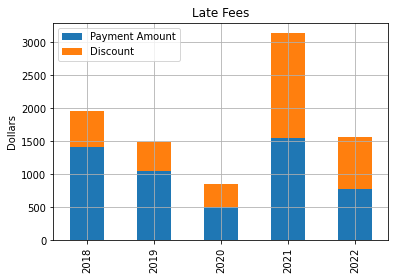

In [5]:
import pandas as pd

transactions = pd.read_pickle('output/transactions.pkl')
transactions['Year'] = transactions['Date'].apply(lambda d: d.year)

payments = transactions[transactions['Payment Method'].notna()]
payments = payments[payments['Year'].isin([2018, 2019, 2020, 2021, 2022])]

late_fees = pd.DataFrame(payments[payments['Type'] == 'Late Fee'])
membership_fees = pd.DataFrame(payments[payments['Type'] == 'Membership Fee'])


graph = late_fees.groupby('Year').sum()[['Payment Amount', 'Discount']].plot.bar(
    stacked=True, title='Late Fees', grid=True, ylabel="Dollars", xlabel="")
# TODO: MyTurn records over-payment donations as negative amounts. Need to think
# more about what kind of stats I'd want to record for late fees.

### Membership Donations

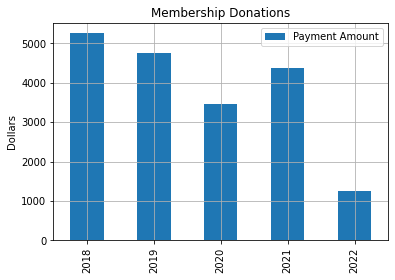

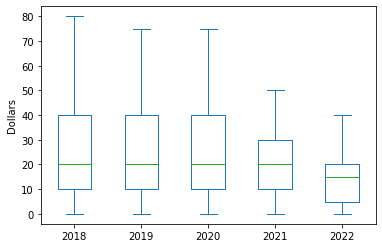

In [6]:
membership_fees['Year'] = membership_fees['Date'].apply(lambda d: d.year)
by_year = membership_fees.groupby('Year')
graph = by_year.sum()[['Payment Amount']].plot.bar(
    stacked=True, title='Membership Donations', grid=True, ylabel="Dollars", xlabel="")

graph = membership_fees[membership_fees['Payment Amount'] >= 0].pivot(columns='Year', values='Payment Amount').plot.box(
    ylabel="Dollars",
    showfliers=False,
)


#### About This Report
Code and instructions for playing with the Capitol Hill Tool Library data yourself are available at https://github.com/mshenfield/chtl-data-pipeline. Ask [Max Shenfield](https://app.slack.com/client/TAAD5LKJ4/D02BHR5J7J6/user_profile/U02BB35KMRU) for access.  The project is built using [Python](https://python.org), [Pandas](https://pandas.pydata.org/), and [Jupyter Notebook](https://jupyter.org/).